**Linear regression**   
    training data; loss function; optimization algorithm; model; vectorization

**Softmax regression**   
multinomial logistic regression; generative model; vectorization

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=trans)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, download=True, transform=trans)

In [3]:
def get_text_labels(labels):
    tlabels = mnist_train.classes
    return [tlabels[int(i)] for i in labels]

In [4]:
import matplotlib.pyplot as plt
def show_img(images, labels):
    _, fig = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, label in zip(fig, images, labels):
        f.imshow(img.reshape(28, 28).numpy())
        f.set_title(label)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

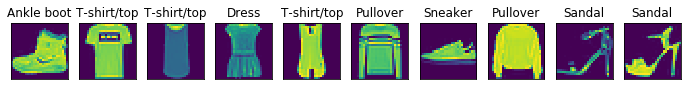

In [5]:
x, y = [], []
n = 0
for data, label in mnist_train:
    x.append(data)
    y.append(label)
    
    n += 1
    if n == 10:
        break
        
show_img(x, get_text_labels(y))

In [6]:
# implementation of softmax regression from scratch
def softmax(x):
    # e^z / sum(e^z)
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)

def net(x):
    # P(y|z) = softmax(xw + b)
    return softmax(torch.mm(x.reshape(-1, 784), w) + b)

def cross_entropy_loss(y_hat, y):
    # choose the correct label in y_hat, compute -log(prob) as loss
    return -torch.gather(y_hat, 1, y.unsqueeze(1)).log()

def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        acc_sum += (net(x).argmax(dim=1) == y).sum().item()
        n += y.size()[0]
    return acc_sum / n

In [11]:
# training
from torch.distributions import normal

w = normal.Normal(loc=0, scale=0.01).sample((784, 10))
b = torch.zeros(10)
w.requires_grad = True
b.requires_grad = True

num_epochs, lr = 5, 0.01
batch_size = 256
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=0)

def train(net, loss, num_epochs, params=None, lr=None):
    optimizer = torch.optim.SGD(params, lr, momentum=0.9)
    # minibatch for efficient performance
    train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=0)
    
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(x)
            l = loss(y_hat, y).mean()
            l.backward()
            optimizer.step()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.size()[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch {}, loss {:.4f}, train accuracy {:.3f}, test accuracy {:.3f}'.format(epoch + 1, train_loss_sum / n, train_acc_sum / n, test_acc))

train(net, cross_entropy_loss, num_epochs, [w, b], lr)

epoch 1, loss 0.0031, train accuracy 0.742, test accuracy 0.796
epoch 2, loss 0.0022, train accuracy 0.816, test accuracy 0.810
epoch 3, loss 0.0020, train accuracy 0.827, test accuracy 0.819
epoch 4, loss 0.0020, train accuracy 0.833, test accuracy 0.821
epoch 5, loss 0.0019, train accuracy 0.838, test accuracy 0.825


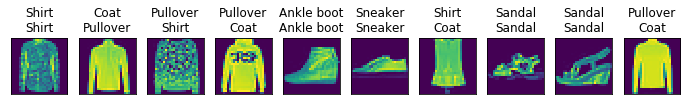

In [12]:
# predictions
for x, y in test_iter:
    break

true_labels = get_text_labels(y.numpy())
pred_labels = get_text_labels(net(x).argmax(dim=1).numpy())
titles = [t + '\n' + p for t, p in zip(true_labels, pred_labels)]
show_img(x[-10:], titles[-10:])

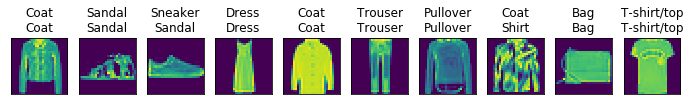

In [13]:
show_img(x[10:20], titles[10:20])

In [15]:
# implementation using package
import torch.nn as nn

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 784)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net = nn.Sequential(Reshape(), nn.Linear(784, 10))
net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [16]:
loss = nn.CrossEntropyLoss()

In [17]:
num_epochs, lr = 10, 0.1

def train(net, loss, num_epochs, lr=None):
    optimizer = torch.optim.SGD(net.parameters(), lr, momentum=0.9)
    # minibatch for efficient performance
    batch_size = 256
    train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=0)
    
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(x)
            l = loss(y_hat, y).mean()
            l.backward()
            optimizer.step()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.size()[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch {}, loss {:.4f}, train accuracy {:.3f}, test accuracy {:.3f}'.format(epoch + 1, train_loss_sum / n, train_acc_sum / n, test_acc))

train(net, loss, num_epochs, lr)

epoch 1, loss 0.0023, train accuracy 0.796, test accuracy 0.825
epoch 2, loss 0.0018, train accuracy 0.841, test accuracy 0.835
epoch 3, loss 0.0018, train accuracy 0.845, test accuracy 0.839
epoch 4, loss 0.0018, train accuracy 0.843, test accuracy 0.835
epoch 5, loss 0.0017, train accuracy 0.849, test accuracy 0.832
epoch 6, loss 0.0017, train accuracy 0.853, test accuracy 0.842
epoch 7, loss 0.0017, train accuracy 0.852, test accuracy 0.842
epoch 8, loss 0.0017, train accuracy 0.854, test accuracy 0.821
epoch 9, loss 0.0017, train accuracy 0.854, test accuracy 0.806
epoch 10, loss 0.0017, train accuracy 0.853, test accuracy 0.841
